In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import scipy.stats as ss

# Make plots larger
plt.rcParams['figure.figsize'] = (15, 9)

In [24]:
facebook = pd.read_excel('fb.xlsx')
facebook.set_index('Date')
facebook['open_tmr'] = facebook['Open '].shift(-1)
facebook['OpenClose']= (facebook['Open ']+ facebook['Close '])/2
facebook['HighLow'] = (facebook['High ']+ facebook['Low '])/2
facebook['OCHL'] = (facebook['Open ']+ facebook['Close ']+facebook['High ']+ facebook['Low '])/4
facebook.head()

Date   Open    High     Low   Close   Volume  open_tmr  OpenClose  \
0 2016-01-04  104.44  104.44   99.75  102.31  345674    102.33    103.375   
1 2016-01-05  102.33  103.71  101.41  102.80  215313    102.02    102.565   
2 2016-01-06  102.02  103.77  100.75  103.17  234525    102.02    102.595   
3 2016-01-07  102.02  102.02   97.30   97.65  419638     99.00     99.835   
4 2016-01-08   99.00  100.50   97.03   97.18  325973     97.80     98.090   

   HighLow      OCHL  
0  102.095  102.7350  
1  102.560  102.5625  
2  102.260  102.4275  
3   99.660   99.7475  
4   98.765   98.4275

In [25]:
#T = 670
X = facebook[['OpenClose']].as_matrix()[1:]
Y = facebook[['open_tmr']].as_matrix()[:-1]
df = facebook[['Close ']]
df.reset_index(level=0, inplace=True)
df.columns=['ds','y']
#X = np.column_stack([np.ones((T,1)),X])
#print(X.transpose().shape)
#movAverage1= (movAvg) 
X.shape

D:\ProgramFiles\Anacondav2\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
D:\ProgramFiles\Anacondav2\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


(670, 1)

In [26]:
def Linear(X, Y):
    
    T = X.shape[0]
    #print(T)
    #mu = (facebook['Open '].mean(),facebook['Open '].mean(),facebook['Open '].mean()) 
    #cov = [[1,0.75,-0.35],[0.75,1,0.9],[-0.35,0.9,1]]
    #F = np.random.multivariate_normal(mu,cov,T)
    #Sample for Y,X
    X = np.column_stack([np.ones((T,1)),X])
    #T = X.shape[0]
    N = X.shape
    #print(N)
    #beta = np.array([0.56,2.53,2.05,1.78])
    #beta.shape=(N[1],1)
    #Y =X@beta+np.random.normal(0,1,(T,1))
    #Y=facebook['Open '].values
    #print(T)
    invXX = np.linalg.inv(X.transpose()@X)
    #print(invXX.shape)
    #print(X.shape)
    beta_hat = invXX@X.transpose()@Y
    #print(beta_hat)
    y_hat = X@beta_hat
#     residuals = Y-y_hat
#     sigma2 = (1/T)*residuals.transpose()@residuals

#     sigma = np.sqrt(sigma2)

#     #variance - covariance of beta_hat
#     varcov_beta_hat = (sigma2)*invXX
#     std_beta_hat = np.sqrt(T*np.diag(varcov_beta_hat))

#     R_square = 1-(residuals.transpose()@residuals)/(T*np.var(Y))

#     adj_R_square = 1-(1-R_square)*(T-1)/(T - N[1])

#     #Testing Coefficents:beta_i
#     #Null Hypotesis

#     t_stat = (beta_hat.transpose()-0)/std_beta_hat
#     p_val = 1-ss.norm.cdf(t_stat)

#     #Test of joint significance
#     F_stat= (beta_hat.transpose()@np.linalg.inv(varcov_beta_hat)@beta_hat/N[1])/(residuals.transpose()@residuals/(T-N[1]))
#     p_val_F= 1 - ss.f.cdf(F_stat,N[1]-1, T-N[1])
    
    return beta_hat,y_hat


In [27]:
y_hat = Linear(X, Y)[1]

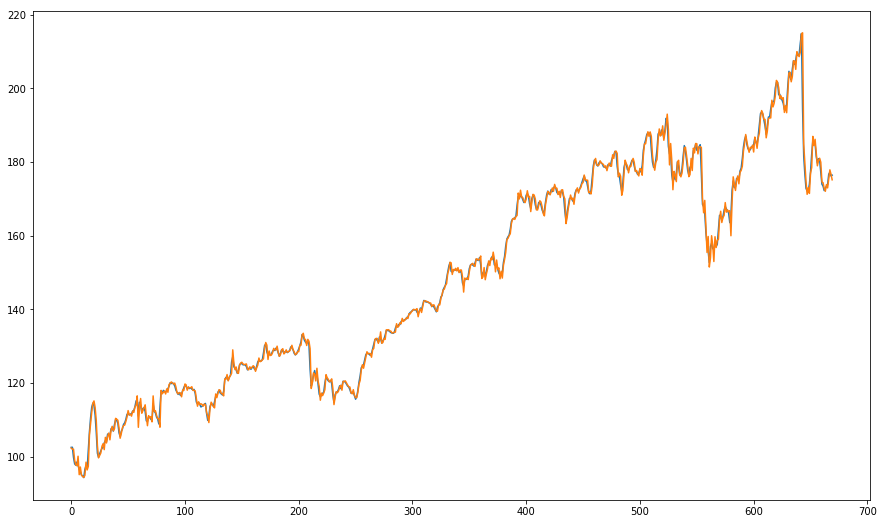

In [28]:
plt.plot(y_hat)
plt.plot(Y)

In [29]:
def linear_bootstrap():
    T = 250
    #print(T)
    N = X.shape[0]
    #print(N)
    
    yhat_linear = np.zeros(N-(T+1))
    window = 200
    num_boost = 300 # increase
    
    for t in range(T+1,N):
        X_train = df.y.ewm(span=5, adjust=False).mean()[t-window:t-1]
        #X_train = np.column_stack([np.ones((len(X_train),1)),X_train])
        Y_train = facebook[['open_tmr']][t-window:t-1].values
        #print(X_train.shape)
        #print(Y_train.shape)
        X_pred = df.y.ewm(span=5, adjust=False).mean()[t-1:t]
        X_pred = np.column_stack([np.ones((len(X_pred),1)),X_pred])
        
        yhat_train = Linear(X_train , Y_train)[1]
        res_train = Y_train - yhat_train
       
        y_pred_all = np.zeros(num_boost)
       
        for i in range (0,num_boost):
            #err = np.random.choice(res_train,(window-1, ),replace = True)
            err = res_train
            y_bstr = yhat_train + err
            beta_bstr = Linear(X_train,y_bstr)[0]
            #print(X_pred.shape)
            #print(beta_bstr.shape)
 
            y_pred_bstr = X_pred@beta_bstr
            y_pred_all[i] = y_pred_bstr
           
        y_pred_linear = y_pred_all.mean()
       
        yhat_linear[t-(T+1)] = y_pred_linear
   
   
    rmse_linear = np.sqrt(np.mean((Y - yhat_linear)**2))
   
    return yhat_linear,rmse_linear

In [30]:
rmse_linear = linear_bootstrap()[1]
rmse_linear

40.35450633069715